# Project Hospi-Tale: A Story Told From the Heart

In [38]:
import project_heart_disease_data as heart
import Heart_data_fit as fitter
import pandas as pd
import numpy as np
%matplotlib inline

### Data Processing

In [39]:
switzerland = heart.get_dfs('../project_2/data/heart_disease/switzerland.data',10)
hungary = heart.get_dfs('../project_2/data/heart_disease/hungarian.data',10)
long_beach = heart.get_dfs('../project_2/data/heart_disease/long-beach-va.data',10)
cleveland = heart.get_dfs('../project_2/data/heart_disease/new.data',12)

In [40]:
all_data = []
for i in range(len(switzerland)):
    switzerland[i]['dataset'] = 'switzerland'
    hungary[i]['dataset'] = 'hungary'
    long_beach[i]['dataset'] = 'long beach'
    #cleveland[i]['dataset'] = 'cleveland'
    all_data.append(pd.concat([switzerland[i],hungary[i],long_beach[i]]).reset_index())

In [41]:
all_data[0] = all_data[0].drop(['pncaden','ekgmo','ekgday','ekgyr','proto','slope'],1)
all_data[0][['restwm','restecg']] = heart.nan_to_num(all_data[0],['restwm','restecg'],'0')
all_data[0]['thal'] = heart.nan_to_num(all_data[0],['thal'],'3')

In [42]:
all_data[1] = all_data[1].drop(['fbs','thaltime','met','ca','restef','exeref','exerwm'],1)
zero_replace = ['relrest','smoke','cigs','smkyrs','diabhist','famhist','dig',
                    'prop','nitr','pro','diu','exang','xhypo','oldpeak']
all_data[1][zero_replace] = heart.nan_to_num(all_data[1],zero_replace,0)
median_replace = ['restbpadmit','chol','thaldur','thalach','thalrest','peakbp1',
                      'peakbp2','restbphos','rldv5','rldv5e']
all_data[1] = heart.nan_to_median(all_data[1],median_replace)

In [43]:
merge_data = pd.merge(all_data[0],all_data[1],left_index=True,right_index=True)
merge_data = merge_data.dropna(axis=0).reset_index()    

### Feature Creation

In [44]:
merge_data.cyr = ['19'+i if 75<int(i)<100 else i for i in merge_data.cyr]
merge_data.cday = merge_data.cday.apply(int)
merge_data.cmo = merge_data.cmo.apply(int)
merge_data.cday =['MB' if x<10 else 'MM' if (10<=x<20) else 'ME' for x in merge_data.cday]
merge_data.cmo =['spring' if 3<=x<6 else 'summer' if (6<=x<9) else 'fall' if (9<=x<12) else 'winter' for x in merge_data.cmo]    
merge_data = merge_data[merge_data.cyr.apply(float) > 100]
features_class = ['cptype','restecg','restwm','thal','cmo','cday','cyr','dataset_y']
for col in features_class: 
    merge_data[col]=merge_data[col].apply(str)
features_numeric= ['index', 'index_x','id', 'index_y', 'age', 'sex',
       'painloc', 'painexer', 'relrest', 'restbpadmit', 'chol', 'smoke',
       'cigs', 'smkyrs', 'diabhist', 'famhist', 'dig', 'prop', 'nitr',
       'pro', 'diu', 'thaldur', 'thalach', 'thalrest', 'peakbp1',
       'peakbp2', 'restbphos', 'exang', 'xhypo', 'oldpeak', 'rldv5',
       'rldv5e', 'num']
for col in features_numeric: 
    merge_data[col]=merge_data[col].apply(float)

In [45]:
from patsy import dmatrices, dmatrix
classes_dummy=dmatrix("cptype + restecg + restwm + thal + cmo + cday + cyr + dataset_y", merge_data, return_type ='dataframe')

In [46]:
merge_data_with_class = pd.concat([merge_data[features_numeric],classes_dummy],axis=1)

### Feature Selection

In [47]:
df = merge_data_with_class
    
features_try = ['age', 'sex','painloc', 'painexer', 'relrest', 'restbpadmit', 'chol', 'smoke',
                'cigs', 'smkyrs', 'diabhist', 'famhist', 'dig', 'prop', 'nitr',
                'pro', 'diu', 'thaldur', 'thalach', 'thalrest', 'peakbp1',
                'peakbp2', 'restbphos', 'exang', 'xhypo', 'oldpeak', 'rldv5',
                'rldv5e', 'num']
features_class_dummy = ['num','cptype[T.2]', 'cptype[T.3]', 'cptype[T.4]', 'restecg[T.1]', 
                        'restecg[T.2]', 'restwm[T.1]', 'restwm[T.2]', 'restwm[T.3]', 'thal[T.2]', 'thal[T.3]',
                        'thal[T.4]', 'thal[T.5]', 'thal[T.6]', 'thal[T.7]', 'cmo[T.spring]', 'cmo[T.summer]', 
                        'cmo[T.winter]', 'cday[T.ME]', 'cday[T.MM]', 'cyr[T.1982]', 'cyr[T.1983]', 'cyr[T.1984]', 
                        'cyr[T.1985]', 'cyr[T.1986]', 'cyr[T.1987]', 'dataset_y[T.long beach]', 'dataset_y[T.switzerland]']
                             

##### Describe Sex

In [48]:
df.sex.describe()

count    605.000000
mean       0.842975
std        0.364125
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: sex, dtype: float64

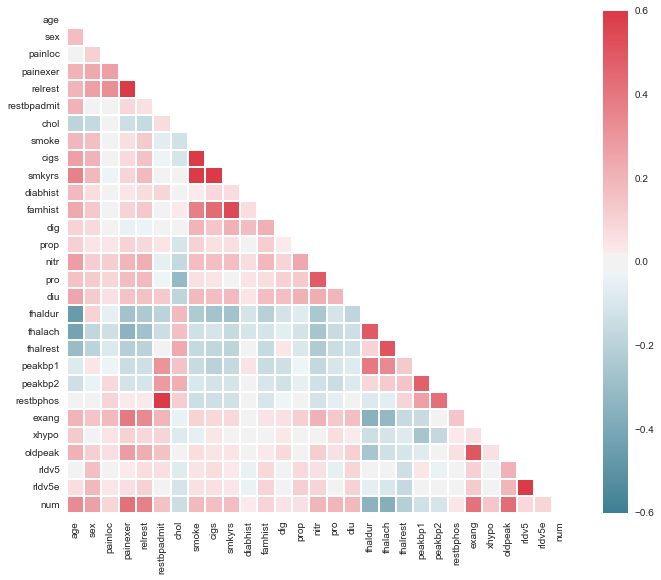

In [49]:
fitter.np = np

cor_df = df[features_try]
cor_try = fitter.corr_matrix(cor_df)

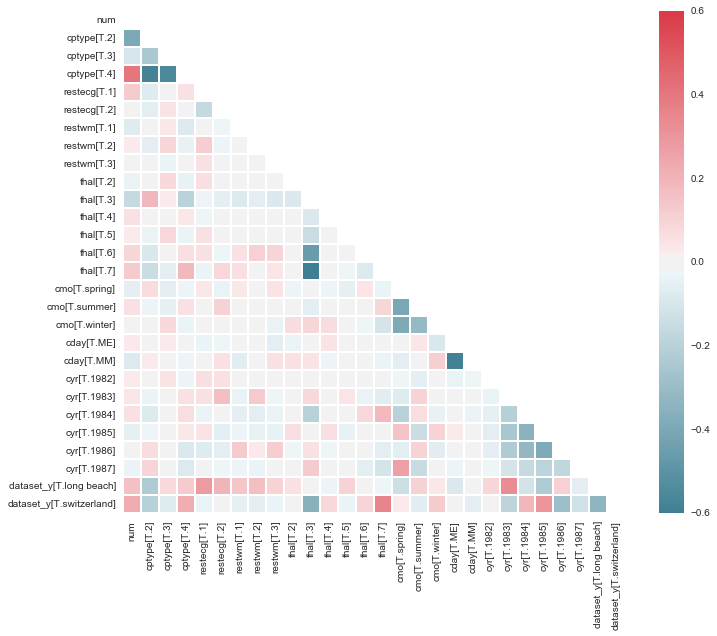

In [50]:
cor_dummy_df = df[features_class_dummy]
cor_dummy_try = fitter.corr_matrix(cor_dummy_df)

In [51]:
var_sel = cor_try[(cor_try.num > 0.1) | (cor_try.num < -0.1)].index
var_class_sel = cor_dummy_try[(cor_dummy_try.num > 0.1) | (cor_dummy_try.num < -0.1)].index
final_col_sel_var = list(var_sel)+list(var_class_sel)
final_col_sel_var.remove('num')
final_col_sel_var.remove('num')
print final_col_sel_var

['age', 'sex', 'painexer', 'relrest', 'restbpadmit', 'chol', 'smoke', 'cigs', 'smkyrs', 'nitr', 'pro', 'diu', 'thaldur', 'thalach', 'thalrest', 'peakbp1', 'peakbp2', 'exang', 'xhypo', 'oldpeak', 'cptype[T.2]', 'cptype[T.3]', 'cptype[T.4]', 'restecg[T.1]', 'thal[T.3]', 'thal[T.7]', 'dataset_y[T.long beach]', 'dataset_y[T.switzerland]']


### Model

In [81]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
    
y = df['num']
y = pd.Series([0 if i ==0 else 1 for i in y])
X = df[final_col_sel_var]

In [103]:
y.value_counts()

1    360
0    245
dtype: int64

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
    
logreg =LogisticRegression()
logreg.fit(X_train,y_train)

from operator import itemgetter
print('The most negatively correlated variable was %s' % X_train.columns[min(enumerate(logreg.coef_[0]), key=itemgetter(1))[0]])
print('The most positively correlated variable was %s' % X_train.columns[max(enumerate(logreg.coef_[0]), key=itemgetter(1))[0]])

The most negatively correlated variable was cptype[T.2]
The most positively correlated variable was dataset_y[T.switzerland]


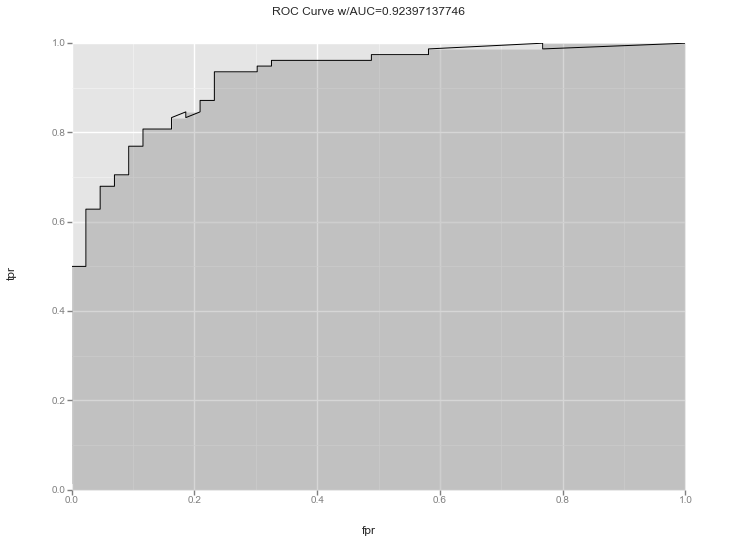

<ggplot: (11843560)>

In [95]:
y_pred=logreg.predict_proba(X_test)[:,1]
fpr, tpr, _=metrics.roc_curve(y_test,y_pred)
   
from ggplot import *
    
df_graph = pd.DataFrame(dict(fpr=fpr,tpr=tpr))
ggplot(df_graph, aes(x='fpr',y='tpr'))+geom_line()
   
auc=metrics.auc(fpr,tpr)
ggplot(df_graph,aes(x='fpr',y='tpr'))+geom_area(alpha=0.2)+\
       geom_line(aes(y='tpr'))+\
       ggtitle('ROC Curve w/AUC=%s' % str(auc))

In [89]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01,penalty="l1",dual=False).fit(X,y)
model = SelectFromModel(lsvc,prefit=True)
X_new = model.transform(X)
X_new_columns = X.columns[model.get_support()]
X_new_df = pd.DataFrame(X_new,columns = X_new_columns)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_new_df,y,test_size=0.2, random_state=42)
    
logreg =LogisticRegression()
logreg.fit(X_train,y_train)

from operator import itemgetter
print('The most negatively correlated variable was %s' % X_train.columns[min(enumerate(logreg.coef_[0]), key=itemgetter(1))[0]])
print('The most positively correlated variable was %s' % X_train.columns[max(enumerate(logreg.coef_[0]), key=itemgetter(1))[0]])

The most negatively correlated variable was thalach
The most positively correlated variable was painexer


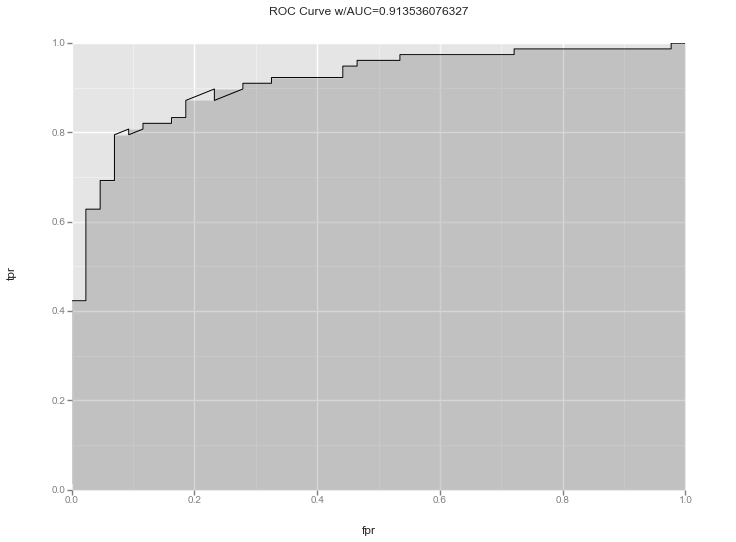

<ggplot: (17135424)>

In [92]:
y_pred=logreg.predict_proba(X_test)[:,1]
fpr, tpr, _=metrics.roc_curve(y_test,y_pred)
   
from ggplot import *
    
df_graph = pd.DataFrame(dict(fpr=fpr,tpr=tpr))
ggplot(df_graph, aes(x='fpr',y='tpr'))+geom_line()
   
auc=metrics.auc(fpr,tpr)
ggplot(df_graph,aes(x='fpr',y='tpr'))+geom_area(alpha=0.2)+\
       geom_line(aes(y='tpr'))+\
       ggtitle('ROC Curve w/AUC=%s' % str(auc))